#**Stacking and Blending (Regression)**

**Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone

**Code**

In [2]:
# Load a regression dataset
data = fetch_california_housing()
X, y = data.data, data.target

In [3]:
# Split the dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Further split the training set into train and validation sets (for stacking)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [5]:
# Define base regressors with more estimators
base_regressors = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('ada', AdaBoostRegressor(n_estimators=100, random_state=42)),
    ('et', ExtraTreesRegressor(n_estimators=100, random_state=42)),
    ('svr', SVR(kernel='rbf')),  # Support Vector Regressor
]

In [6]:
# Step 1: Train base regressors on the training set
val_predictions = np.zeros((X_val.shape[0], len(base_regressors)))  # Placeholder for validation predictions
test_predictions = np.zeros((X_test.shape[0], len(base_regressors)))  # Placeholder for test set predictions
fitted_regressors = []  # To store fitted regressor instances

for i, (name, reg) in enumerate(base_regressors):
    # Clone the regressor to avoid overwriting during stacking
    reg_instance = clone(reg)

    # Train on the full training set
    reg_instance.fit(X_train, y_train)
    fitted_regressors.append(reg_instance)  # Store the fitted instance

    # Store predictions on the validation set (for blending)
    val_predictions[:, i] = reg_instance.predict(X_val)

    # Store predictions on the test set
    test_predictions[:, i] = reg_instance.predict(X_test)

In [7]:
# Step 2: Stack the base regressor predictions and train a meta-regressor
stacking_meta_regressor = LinearRegression()
stacking_meta_regressor.fit(val_predictions, y_val)

LinearRegression()

In [8]:
# Step 3: Make final predictions on the test set using the stacking meta-regressor
final_stacking_predictions = stacking_meta_regressor.predict(test_predictions)

In [9]:
# Calculate and display metrics of the stacking model
stacking_mse = mean_squared_error(y_test, final_stacking_predictions)
stacking_r2 = r2_score(y_test, final_stacking_predictions)
print(f'Stacking Model MSE: {stacking_mse:.2f}, R2: {stacking_r2:.2f}')

Stacking Model MSE: 0.26, R2: 0.80


In [10]:
# Step 4: Blending approach
# Blending predictions from base regressors on the test set using Linear Regression
blender = LinearRegression()
blender.fit(val_predictions, y_val)

LinearRegression()

In [11]:
# Make final predictions using the blender
final_blender_predictions = blender.predict(test_predictions)

In [12]:
# Calculate and display metrics of the blended model
blender_mse = mean_squared_error(y_test, final_blender_predictions)
blender_r2 = r2_score(y_test, final_blender_predictions)
print(f'Blended Model MSE: {blender_mse:.2f}, R2: {blender_r2:.2f}')

Blended Model MSE: 0.26, R2: 0.80


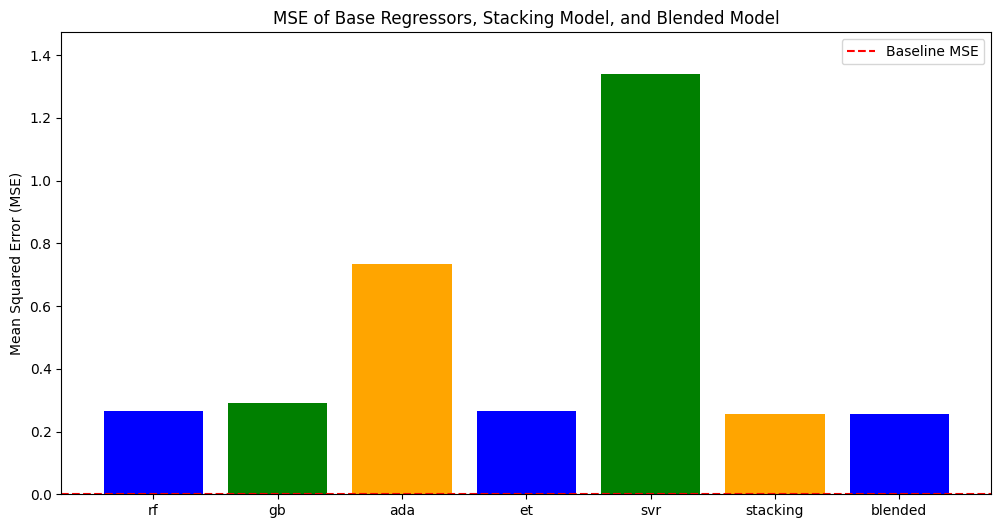

In [13]:
# Visualize individual regressor performance, stacking model, and blended model performance
individual_mse = []

for reg_instance, (name, _) in zip(fitted_regressors, base_regressors):
    reg_pred = reg_instance.predict(X_test)
    mse = mean_squared_error(y_test, reg_pred)
    individual_mse.append((name, mse))

# Plot individual regressor MSE vs. stacking and blended model MSE
names, mses = zip(*individual_mse)
plt.figure(figsize=(12, 6))
plt.bar(names + ('stacking', 'blended'), mses + (stacking_mse, blender_mse), color=['blue', 'green', 'orange'])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE of Base Regressors, Stacking Model, and Blended Model')
plt.ylim(0, max(mses + (stacking_mse, blender_mse)) * 1.1)  # Set y-limits for better visualization
plt.axhline(y=0, color='red', linestyle='--', label='Baseline MSE')
plt.legend()
plt.show()

In [14]:
# Visualizing Predictions vs Actual for Stacking and Blended Models
def plot_predictions_vs_actual(y_true, y_pred, title='Predictions vs Actual'):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.xlim(y.min(), y.max())
    plt.ylim(y.min(), y.max())
    plt.grid()
    plt.show()

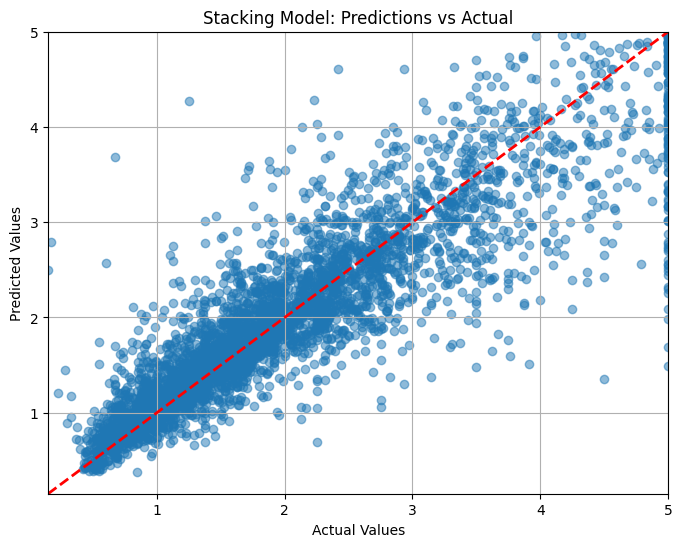

In [15]:
# Predictions vs Actual for Stacking Model
plot_predictions_vs_actual(y_test, final_stacking_predictions, title='Stacking Model: Predictions vs Actual')

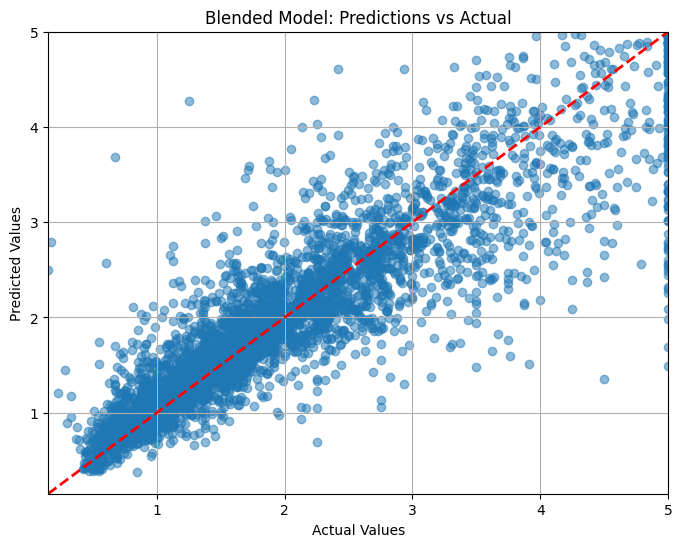

In [16]:
# Predictions vs Actual for Blended Model
plot_predictions_vs_actual(y_test, final_blender_predictions, title='Blended Model: Predictions vs Actual')